In [172]:

import matplotlib
from matplotlib import pyplot as plt
#from ren import renAlgo
import scipy
import scipy.signal
import numpy as np
import os
#from calibrate import focal2distance
import pickle
import cv2
from huHann import huHann
import copy

In [177]:
def neighbourReplace(src,size,thresh=49):
    csrc=copy.copy(src)
    Rf=scipy.ndimage.maximum_filter(src,size=size)
    csrc[np.where(csrc<=thresh)]= Rf[np.where(csrc<=thresh)]
    return src
#def outofStDFilt(src,sigma): # if pix is out of sigma of neighbours, then toss and replace with mean

In [178]:
def calibrate(x):
    return 0.004179093 - (-0.0001941383/-12.98214)*(1 - np.exp(12.98214*x))
def rcalibrate(y):
    return 0.0770289*np.log(66870.6 *(y - 0.00416414))

In [179]:
def renAlgo(files):
    confMaps=[]
    for index, filename in enumerate(files):
        print(filename)
        im = cv2.imread(filename)
        
        img=im[:,:,2].astype(int)
        blurmap=huHann(img)
#         plt.figure()
#         plt.imshow(blurmap,cmap="gray")
        nmap=(8-blurmap)/8
#         plt.figure()
#         plt.imshow(nmap,cmap="gray")
        blur = cv2.GaussianBlur(nmap,(99,99),0)
        blur = cv2.GaussianBlur(blur,(99,99),0) # second order
#         plt.figure()
#         plt.imshow(blur,cmap="gray")
        confMaps.append(blur)
    flatConf=np.array(confMaps)
    return flatConf
    

In [180]:
goodStuff=renAlgo(["86_0.jpg","86_1.jpg","86_2.jpg","86_3.jpg","86_4.jpg","86_5.jpg","86_6.jpg","86_7.jpg"])

86_0.jpg
86_1.jpg
86_2.jpg
86_3.jpg
86_4.jpg
86_5.jpg
86_6.jpg
86_7.jpg


In [181]:

focal=[0.6, 0.65, 0.70, 0.72, 0.75, 0.78, 0.8, 0.95]
calDistance=list(map(lambda x :calibrate(x)+0.05,focal))
calDistance=calDistance/max(calDistance)

flatConf=goodStuff
semiFlatConf=goodStuff

In [122]:



flatConf=semiFlatConf.reshape(semiFlatConf.shape[0],-1)
print(flatConf.shape)
max_idx=flatConf.argmax(0)
print(max_idx)
depth_1d=np.array(list(map(lambda x: focal[x],max_idx)))
oneDepth=depth_1d.reshape(semiFlatConf.shape[1],semiFlatConf.shape[2])


(8, 12192768)
[6 6 6 ..., 1 1 1]


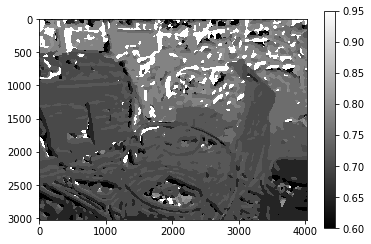

In [182]:
#%matplotlib
plt.imshow(oneDepth,cmap="gray")
plt.colorbar()

In [183]:
normalize=255*(oneDepth-min(focal))/(max(focal)-min(focal))

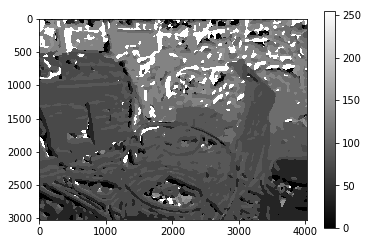

In [184]:
plt.imshow(normalize,cmap="gray")
plt.colorbar()

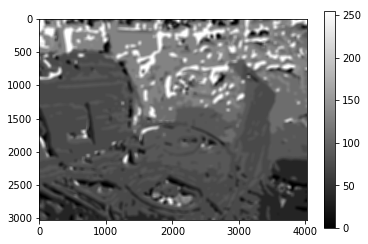

In [185]:
mu=  cv2.blur(normalize, (50,50))
plt.imshow(mu,cmap="gray")
plt.colorbar()

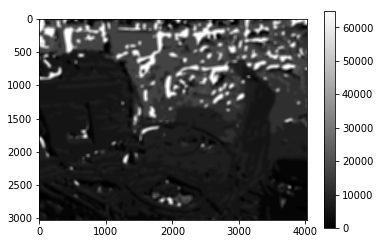

In [186]:
mu2= cv2.blur(np.multiply(normalize,normalize), (50,50));
plt.imshow(mu2,cmap="gray")
plt.colorbar()

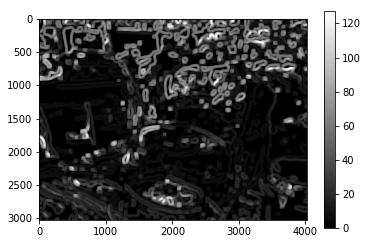

In [187]:

sigma=cv2.sqrt(np.abs(mu2 - np.multiply(mu,mu)))
plt.imshow(sigma,cmap="gray")
plt.colorbar()

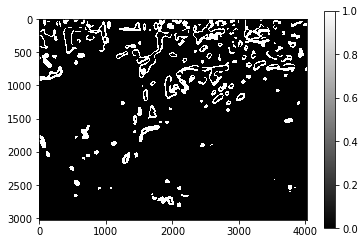

In [188]:
bisigma=copy.copy(sigma)
tresh=bisigma.max()*0.45
bisigma[np.where(bisigma>tresh)]= 120
bisigma[np.where(bisigma<=tresh)]= 0
plt.imshow(bisigma/120,cmap="gray")
plt.colorbar()

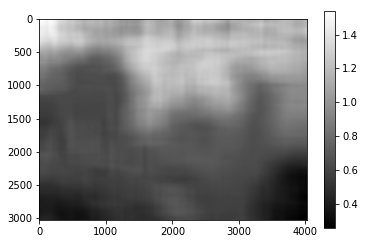

In [189]:
fatblur=cv2.blur(normalize, (500,500))
plt.imshow(fatblur/120,cmap="gray")
plt.colorbar()

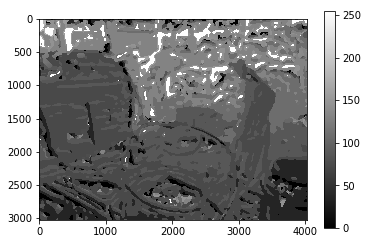

In [190]:
new_normalize=copy.copy(normalize)

new_normalize[np.where(bisigma>0.5)]= fatblur[np.where(bisigma>0.5)]
plt.imshow(new_normalize,cmap="gray")
plt.colorbar()

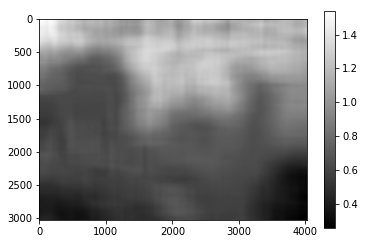

In [191]:
fatblur=cv2.blur(normalize, (500,500))
plt.imshow(fatblur/120,cmap="gray")
plt.colorbar()

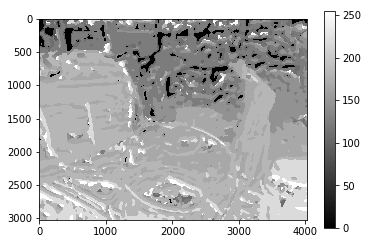

In [192]:
bam=255-new_normalize
plt.imshow(bam,cmap="gray")
plt.colorbar()

In [193]:
bam.std()

43.535735981238233

In [194]:
np.histogram(bam,30)

(array([ 373474,       0,       0,       0,       0,       0,       0,
              0,    3085,    9254,    7647,   50416,  435304,  256396,
        1804148,   80939,   46532, 1243952,   27243, 2446601,   70544,
        3808693,    7573,    2423,    3081, 1224130,       0,       0,
              0,  291333]),
 array([ -2.84217094e-14,   8.50000000e+00,   1.70000000e+01,
          2.55000000e+01,   3.40000000e+01,   4.25000000e+01,
          5.10000000e+01,   5.95000000e+01,   6.80000000e+01,
          7.65000000e+01,   8.50000000e+01,   9.35000000e+01,
          1.02000000e+02,   1.10500000e+02,   1.19000000e+02,
          1.27500000e+02,   1.36000000e+02,   1.44500000e+02,
          1.53000000e+02,   1.61500000e+02,   1.70000000e+02,
          1.78500000e+02,   1.87000000e+02,   1.95500000e+02,
          2.04000000e+02,   2.12500000e+02,   2.21000000e+02,
          2.29500000e+02,   2.38000000e+02,   2.46500000e+02,
          2.55000000e+02]))

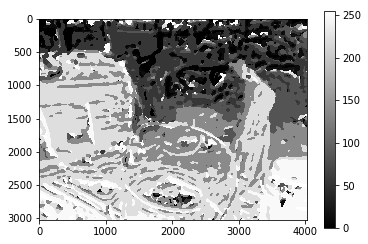

In [195]:
eqed=cv2.equalizeHist(bam.astype(np.uint8))
plt.imshow(eqed,cmap="gray")
plt.colorbar()

In [196]:


n_mu=  cv2.blur(new_normalize, (100,100))
n_mu2= cv2.blur(np.multiply(new_normalize,new_normalize), (100,100));
n_sigma=cv2.sqrt(np.abs(n_mu2 - np.multiply(n_mu,n_mu)))
n_bisigma=copy.copy(n_sigma)
n_tresh=bisigma.max()*0.45
fatblur=cv2.blur(normalize, (500,500))
new_new_normalize[np.where(n_bisigma>n_tresh)]= fatblur[np.where(n_bisigma>n_tresh)]

result=cv2.blur(new_normalize,(25,25))


NameError: name 'new_new_normalize' is not defined

In [ ]:
plt.imshow(result,cmap="gray")
plt.colorbar()